<a href="https://colab.research.google.com/github/anjalii-s/Thesis-2026-/blob/main/LC_4_downsampled_experiment_24_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install shap scikit-learn pandas numpy matplotlib seaborn xgboost -q


In [11]:
# ============================================
# FORCE DATASET TO 4% DEFAULT RATE
# ============================================

df = pd.read_csv("LC_50K.csv")

# Rename target if needed
if "Default" in df.columns:
    df = df.rename(columns={"Default": "target"})

# Separate classes
df_pos = df[df["target"] == 1]   # defaults
df_neg = df[df["target"] == 0]   # non-defaults

# Desired ratio: 4% default
desired_default_rate = 0.04

# Compute required number of negatives
n_pos = len(df_pos)
n_neg_needed = int(n_pos * (1 - desired_default_rate) / desired_default_rate)

# Cap at available negatives
n_neg_needed = min(n_neg_needed, len(df_neg))

# Downsample negatives
df_neg_down = df_neg.sample(n=n_neg_needed, random_state=42)

# Combine
df_balanced = pd.concat([df_pos, df_neg_down], axis=0)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("New shape:", df_balanced.shape)
print(df_balanced["target"].value_counts(normalize=True))


New shape: (50000, 15)
target
0    0.96
1    0.04
Name: proportion, dtype: float64



LOADING AND PREPROCESSING LENDING CLUB (LC_50K) DATASET
Original shape: (50000, 10), After 4% default balancing: (50000, 10)
New target distribution:
target
0    0.96
1    0.04
Name: proportion, dtype: float64
Capped dataset to 12000 rows. New shape: (12000, 10)

Final dataset shape: (12000, 9)
Default rate: 4.02%
Imbalance ratio: 23.90:1

Categorical columns (5): ['experience_c', 'emp_length', 'purpose', 'home_ownership_n', 'addr_state']
Numeric columns (4): ['revenue', 'dti_n', 'loan_amnt', 'fico_n']...

Number of processed features: 80
First 10 feature names: ['cat__emp_length_10+ years' 'cat__emp_length_2 years'
 'cat__emp_length_3 years' 'cat__emp_length_4 years'
 'cat__emp_length_5 years' 'cat__emp_length_6 years'
 'cat__emp_length_7 years' 'cat__emp_length_8 years'
 'cat__emp_length_9 years' 'cat__emp_length_< 1 year']

Class weights: {0: 0.5209237714881055, 1: 12.448132780082988}

STARTING UNIFIED EXPERIMENT - ALL 6 EXPLANATION METHODS (LC)

Building feature graph for Myerson 

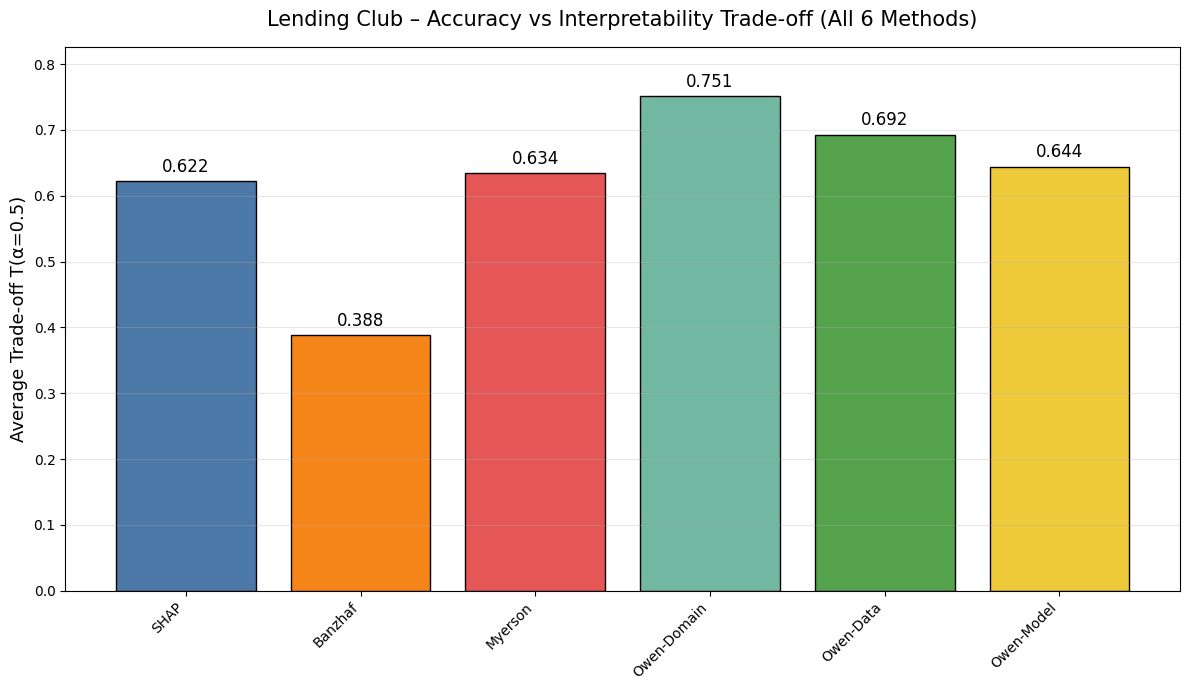

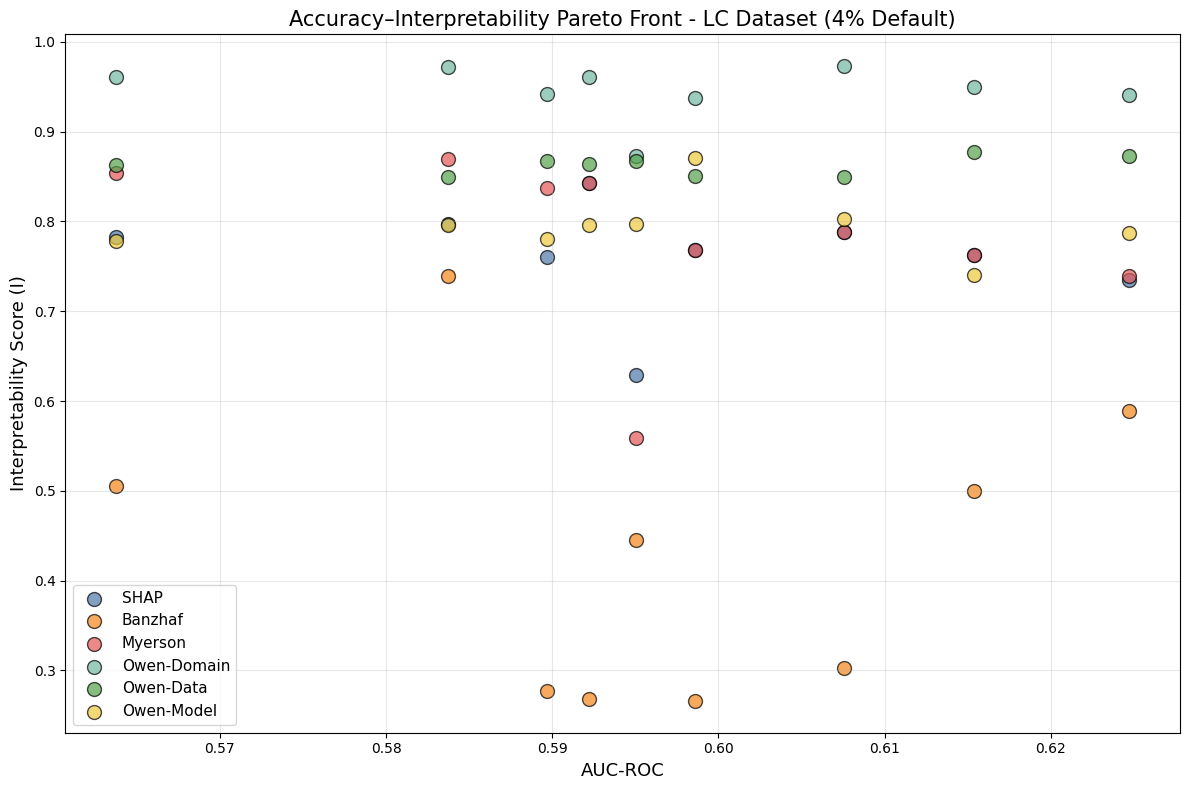

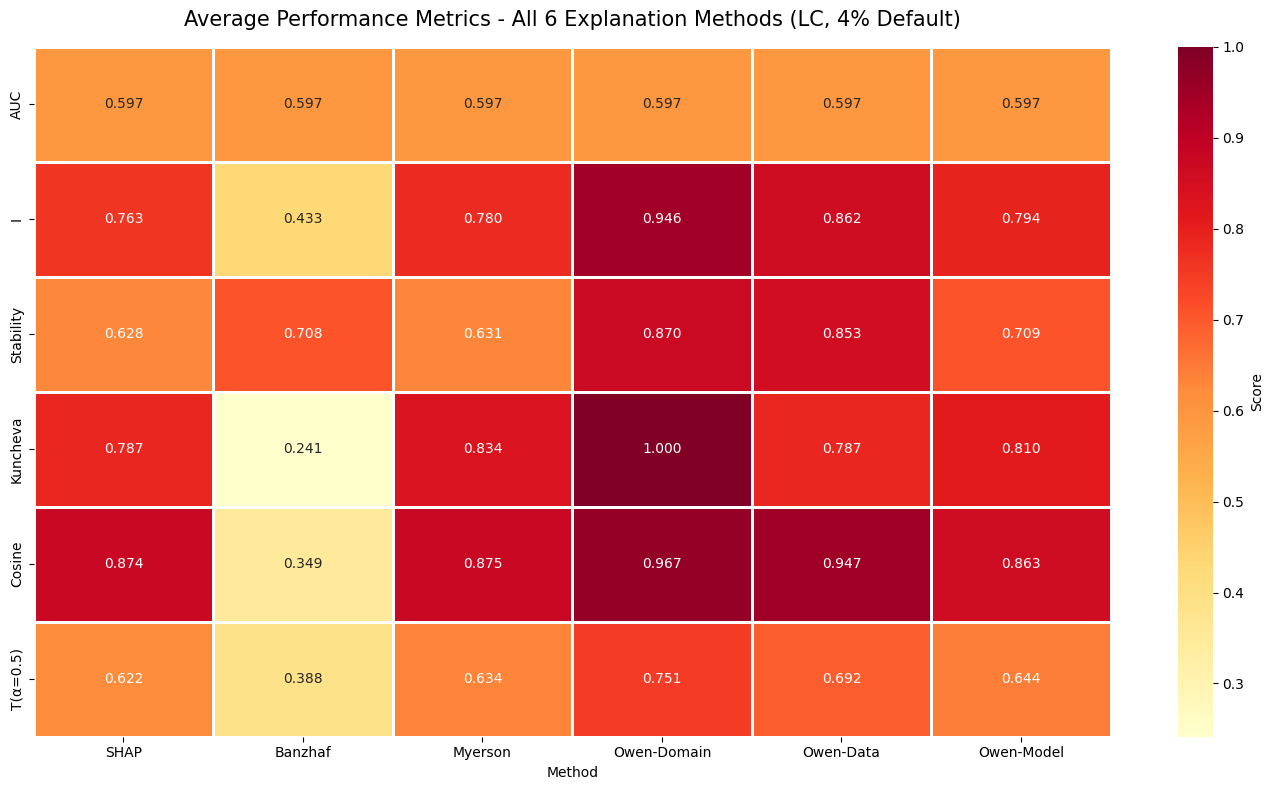

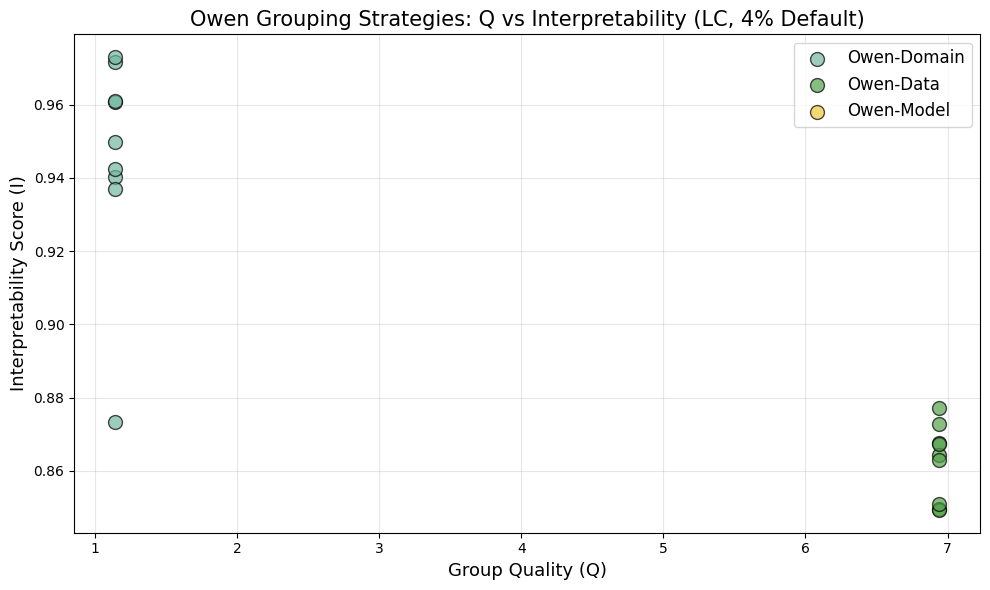


STATISTICAL ANALYSIS - ALL 6 METHODS (LC, 4% DEFAULT)

Methods with complete data: ['Banzhaf', 'Myerson', 'Owen-Data', 'Owen-Domain', 'Owen-Model', 'SHAP']

Friedman test on T(α=0.5): χ²=38.5238, p=2.9610e-07

Post-hoc Nemenyi test (scikit-posthocs):
             Banzhaf  Myerson  Owen-Data  Owen-Domain  Owen-Model    SHAP
Banzhaf       1.0000   0.0621     0.0003       0.0000      0.1583  0.4084
Myerson       0.0621   1.0000     0.6566       0.0436      0.9990  0.9509
Owen-Data     0.0003   0.6566     1.0000       0.7357      0.4084  0.1583
Owen-Domain   0.0000   0.0436     0.7357       1.0000      0.0135  0.0022
Owen-Model    0.1583   0.9990     0.4084       0.0135      1.0000  0.9960
SHAP          0.4084   0.9509     0.1583       0.0022      0.9960  1.0000


In [12]:
# ============================================================
# LENDING CLUB (LC_50K) - UNIFIED GAME THEORY EXPLAINABILITY
# Optimized for i3 / 4GB RAM / Colab free tier
# Target downsampled to ~4% default rate
# ============================================================

!pip install xgboost shap imbalanced-learn lightgbm scikit-posthocs seaborn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
import networkx as nx
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import cosine

from scipy.stats import friedmanchisquare
import scikit_posthocs as sp

plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

# ============================================================
# 1. LOAD, FORCE 4% DEFAULT, PREPROCESS
# ============================================================
print("\n" + "="*80)
print("LOADING AND PREPROCESSING LENDING CLUB (LC_50K) DATASET")
print("="*80)

df = pd.read_csv('LC_50K.csv')

# Ensure target column is named 'target'
if 'Default' in df.columns:
    df = df.rename(columns={'Default': 'target'})

# Drop obvious ID / leakage columns if present
cols_to_drop = ['id', 'issue_d', 'zip_code', 'title', 'desc']
cols_to_drop = [c for c in cols_to_drop if c in df.columns]
df = df.drop(columns=cols_to_drop)

# Handle missing values
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype in ['int64', 'float64']:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)

# ------------------------------------------------------------
# Force dataset to ~4% default rate (class 1)
# ------------------------------------------------------------
df_pos = df[df['target'] == 1]
df_neg = df[df['target'] == 0]

desired_default_rate = 0.04
n_pos = len(df_pos)
if n_pos == 0:
    raise ValueError("No positive (default) samples found in dataset.")

n_neg_needed = int(n_pos * (1 - desired_default_rate) / desired_default_rate)
n_neg_needed = min(n_neg_needed, len(df_neg))

df_neg_down = df_neg.sample(n=n_neg_needed, random_state=42)
df_balanced = pd.concat([df_pos, df_neg_down], axis=0)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Original shape: {df.shape}, After 4% default balancing: {df_balanced.shape}")
print("New target distribution:")
print(df_balanced['target'].value_counts(normalize=True))

# Optional: cap total size to keep things light (e.g., max 12k rows)
max_rows = 12000
if len(df_balanced) > max_rows:
    df_balanced = df_balanced.sample(n=max_rows, random_state=42).reset_index(drop=True)
    print(f"Capped dataset to {max_rows} rows. New shape: {df_balanced.shape}")

X = df_balanced.drop('target', axis=1)
y = df_balanced['target'].astype(int)

print(f"\nFinal dataset shape: {X.shape}")
print(f"Default rate: {(y.mean() * 100):.2f}%")
print(f"Imbalance ratio: {sum(y==0)/sum(y==1):.2f}:1")

# Identify categorical and numeric columns
cat_cols = ['experience_c', 'emp_length', 'purpose', 'home_ownership_n', 'addr_state']
cat_cols = [c for c in cat_cols if c in X.columns]
num_cols = [c for c in X.columns if c not in cat_cols]

print(f"\nCategorical columns ({len(cat_cols)}): {cat_cols}")
print(f"Numeric columns ({len(num_cols)}): {num_cols[:10]}...")

cat_categories = [sorted(X[col].dropna().unique().tolist()) for col in cat_cols]
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore',
                          sparse_output=False, categories=cat_categories), cat_cols),
    ('num', StandardScaler(), num_cols)
])

X_processed = preprocessor.fit_transform(X)
fnames = preprocessor.get_feature_names_out()
d = X_processed.shape[1]

print(f"\nNumber of processed features: {d}")
print(f"First 10 feature names: {fnames[:10]}")

# ============================================================
# 2. MODELS & SAMPLING STRATEGIES (LIGHTWEIGHT)
# ============================================================
models = {
    'RF': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'XGB': xgb.XGBClassifier(n_estimators=100, max_depth=6, random_state=42,
                             eval_metric='logloss', n_jobs=-1),
    'LGB': lgb.LGBMClassifier(n_estimators=100, max_depth=6, random_state=42,
                              verbose=-1, n_jobs=-1)
}

# Keep 3 samplers: None, SMOTE, CostSensitive
resamplers = {
    'None': None,
    'SMOTE': SMOTE(random_state=42),
    'CostSensitive': 'cost'
}

classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weight_dict = {int(cls): float(w) for cls, w in zip(classes, weights)}
print(f"\nClass weights: {class_weight_dict}")

# ============================================================
# 3. EXPLANATION METHODS (6 METHODS, LIGHTWEIGHT)
# ============================================================
def get_shap_reliable(pipe, X_test, max_bg=50, max_explain=50):
    """Get SHAP values for a trained pipeline, with strong caps."""
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)

    if X_proc.shape[0] > max_explain:
        X_proc = X_proc[:max_explain]
        X_test = X_test.iloc[:max_explain]

    bg = X_proc[:min(max_bg, X_proc.shape[0])]

    try:
        explainer = shap.TreeExplainer(clf, data=bg)
        sv = explainer.shap_values(X_proc)
        if isinstance(sv, list):
            return sv[1]
        elif sv.ndim == 3:
            return sv[:, :, 1]
        else:
            return sv
    except Exception as e:
        print(f"SHAP failed: {e}. Using permutation importance fallback...")
        from sklearn.inspection import permutation_importance
        res = permutation_importance(clf, X_proc, pipe.predict(X_test),
                                     n_repeats=3, random_state=42)
        return np.tile(res.importances_mean, (X_proc.shape[0], 1))

def compute_banzhaf(pipe, X_test, n_samples=10, max_instances=2):
    """Compute Banzhaf values (very lightweight)."""
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    n_feat = X_proc.shape[1]
    n_inst = min(max_instances, X_proc.shape[0])
    mat = np.zeros((n_inst, n_feat))

    baseline = X_proc.mean(axis=0, keepdims=True)

    for i in range(n_inst):
        x = X_proc[i:i+1]
        for f in range(n_feat):
            contrib = []
            for _ in range(n_samples):
                coal = np.random.binomial(1, 0.5, n_feat)
                x_with = baseline.copy()
                x_with[0, coal == 1] = x[0, coal == 1]
                p1 = clf.predict_proba(x_with)[0, 1]

                x_without = baseline.copy()
                coal_without = coal.copy()
                coal_without[f] = 0
                x_without[0, coal_without == 1] = x[0, coal_without == 1]
                p0 = clf.predict_proba(x_without)[0, 1]
                contrib.append(p1 - p0)
            mat[i, f] = np.mean(contrib)
    return mat

def build_feature_graph(preprocessor, X, threshold=0.4):
    """Build feature graph for Myerson (global, once)."""
    X_sample = X.sample(n=min(3000, len(X)), random_state=42)
    X_proc = preprocessor.transform(X_sample)
    corr = np.corrcoef(X_proc.T)
    corr = np.nan_to_num(corr, nan=0.0)
    G = nx.Graph()
    d_graph = corr.shape[0]
    G.add_nodes_from(range(d_graph))
    for i in range(d_graph):
        for j in range(i+1, d_graph):
            if abs(corr[i, j]) >= threshold:
                G.add_edge(i, j, weight=corr[i, j])
    return G, np.abs(corr)

def compute_myerson_from_shap_mean(shap_mean, G, alpha=0.5):
    """Compute Myerson values from SHAP mean and feature graph."""
    d_local = len(shap_mean)
    phi = np.zeros(d_local)
    for i in range(d_local):
        neighbors = [n for n in G.neighbors(i) if n < d_local]
        if len(neighbors) == 0:
            phi[i] = shap_mean[i]
        else:
            neighbor_mean = np.mean([shap_mean[j] for j in neighbors])
            phi[i] = (1 - alpha) * shap_mean[i] + alpha * neighbor_mean
    return phi

# ============================================================
# 3B. OWEN GROUPING STRATEGIES (DOMAIN / DATA / MODEL)
# ============================================================
def build_domain_groups_lc(fnames):
    groups = {
        "Domain_EmploymentIncome": [],
        "Domain_LoanTerms": [],
        "Domain_CreditHistory": [],
        "Domain_Delinquency": [],
        "Domain_Utilization": [],
        "Domain_Purpose": [],
        "Domain_AssetsCollateral": [],
        "Domain_Location": []
    }

    for i, name in enumerate(fnames):
        lname = name.lower()

        if any(k in lname for k in [
            "experience_c", "emp_length", "annual_inc", "revenue", "dti", "dti_n", "fico"
        ]):
            groups["Domain_EmploymentIncome"].append(i)

        if any(k in lname for k in [
            "loan_amnt", "term", "installment", "int_rate"
        ]):
            groups["Domain_LoanTerms"].append(i)

        if any(k in lname for k in [
            "open_acc", "total_acc", "revol_bal", "revol_util", "inq_last", "inq_last_6mths"
        ]):
            groups["Domain_CreditHistory"].append(i)

        if any(k in lname for k in [
            "delinq", "pub_rec", "collections", "chargeoff"
        ]):
            groups["Domain_Delinquency"].append(i)

        if any(k in lname for k in [
            "revol_util", "revol_bal", "utilization"
        ]):
            groups["Domain_Utilization"].append(i)

        if "purpose" in lname:
            groups["Domain_Purpose"].append(i)

        if "home_ownership" in lname or "home_ownership_n" in lname:
            groups["Domain_AssetsCollateral"].append(i)

        if "addr_state" in lname or "state" in lname:
            groups["Domain_Location"].append(i)

    return {g: v for g, v in groups.items() if len(v) > 0}

def build_data_groups(X_proc, n_groups=5):
    try:
        X_proc = np.nan_to_num(X_proc, nan=0.0)
        corr = np.corrcoef(X_proc.T)
        corr = np.nan_to_num(corr, nan=0.0)
        np.fill_diagonal(corr, 1.0)
        corr = np.clip(corr, -1.0, 1.0)

        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)

        if X_proc.shape[1] < n_groups:
            n_groups = max(2, X_proc.shape[1] // 2)

        clustering = AgglomerativeClustering(
            n_clusters=n_groups,
            metric='precomputed',
            linkage='average'
        )
        labels = clustering.fit_predict(dist)

        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Data_Cluster_{lab}", []).append(idx)

        return groups, np.abs(corr)
    except Exception as e:
        print(f"Data-driven grouping failed: {e}")
        n_features = X_proc.shape[1]
        return {"Data_Default": list(range(n_features))}, np.eye(n_features)

def build_model_groups(shap_vals, n_groups=5):
    try:
        shap_vals = np.nan_to_num(shap_vals, nan=0.0)

        if shap_vals.ndim == 1:
            shap_vals = shap_vals.reshape(1, -1)
        if shap_vals.shape[0] < shap_vals.shape[1]:
            shap_vals = shap_vals.T

        if shap_vals.shape[0] < 2:
            n_features = shap_vals.shape[1] if shap_vals.shape[0] == 1 else shap_vals.shape[0]
            return {"Model_Default": list(range(n_features))}, np.eye(n_features)

        corr = np.corrcoef(shap_vals)
        corr = np.nan_to_num(corr, nan=0.0)
        np.fill_diagonal(corr, 1.0)
        corr = np.clip(corr, -1.0, 1.0)

        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)

        n_features = corr.shape[0]
        if n_features < n_groups:
            n_groups = max(2, n_features // 2)

        clustering = AgglomerativeClustering(
            n_clusters=n_groups,
            metric='precomputed',
            linkage='average'
        )
        labels = clustering.fit_predict(dist)

        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Model_Group_{lab}", []).append(idx)

        return groups, np.abs(corr)
    except Exception as e:
        print(f"Model-driven grouping failed: {e}")
        n_features = shap_vals.shape[1] if shap_vals.ndim > 1 else shap_vals.shape[0]
        return {"Model_Default": list(range(n_features))}, np.eye(n_features)

def owen_from_shap(phi, groups):
    d_local = len(phi)
    out = np.zeros(d_local)

    for _, feats in groups.items():
        if len(feats) == 0:
            continue
        valid_feats = [f for f in feats if f < d_local]
        if not valid_feats:
            continue
        total = np.sum(np.abs(phi[valid_feats]))
        per = total / len(valid_feats)
        for f in valid_feats:
            sign = np.sign(phi[f]) if phi[f] != 0 else 1
            out[f] = sign * per
    return out

def compute_Q(groups, dep):
    try:
        d_local = dep.shape[0]
        group_id = np.full(d_local, -1)

        for gid, (_, feats) in enumerate(groups.items()):
            for f in feats:
                if f < d_local:
                    group_id[f] = gid

        within, across = [], []
        for i in range(d_local):
            for j in range(i+1, d_local):
                if group_id[i] == group_id[j] and group_id[i] != -1:
                    within.append(dep[i, j])
                elif group_id[i] != -1 and group_id[j] != -1:
                    across.append(dep[i, j])

        if len(within) == 0 or len(across) == 0:
            return np.nan

        within_mean = np.mean(within)
        across_mean = np.mean(across)
        if across_mean == 0:
            return np.nan
        return float(within_mean / across_mean)
    except:
        return np.nan

# ============================================================
# 4. METRICS (CV, KUNCHEVA, COSINE, I, T)
# ============================================================
def stability_cv(expl_list):
    if len(expl_list) < 2:
        return 1.0
    try:
        arr = np.stack(expl_list)
        mean = arr.mean(axis=0) + 1e-8
        std = arr.std(axis=0)
        cv_per_feature = std / mean
        return float(np.mean(cv_per_feature))
    except:
        return 1.0

def kuncheva_index(expl_list, k=5):
    if len(expl_list) < 2:
        return 0.0

    d_local = len(expl_list[0])
    sets = []
    for imp in expl_list:
        imp = np.abs(imp).ravel()
        topk = min(k, len(imp))
        topk_indices = set(np.argsort(imp)[-topk:].tolist())
        sets.append(topk_indices)

    if len(sets) < 2:
        return 0.0

    ki_values = []
    for i in range(len(sets)):
        for j in range(i+1, len(sets)):
            intersection = len(sets[i] & sets[j])
            if k == d_local:
                ki = 0.0
            else:
                ki = (intersection - (k**2)/d_local) / (k - (k**2)/d_local)
            ki = max(min(ki, 1.0), -1.0)
            ki_values.append(ki)

    return float(np.mean(ki_values)) if ki_values else 0.0

def cosine_directional_consistency(expl_list):
    if len(expl_list) < 2:
        return 0.0

    K = len(expl_list)
    cos_sims = []
    for p in range(K):
        for s in range(p+1, K):
            v_p = expl_list[p]
            v_s = expl_list[s]
            cos_val = 1 - cosine(v_p, v_s)
            cos_sims.append(cos_val)

    if not cos_sims:
        return 0.0
    return float(np.mean(cos_sims))

def interpretability_score(cv, kuncheva, cosine_score, beta=1/3):
    return beta * (1 - cv) + beta * kuncheva + beta * cosine_score

def normalize(s):
    return (s - s.min()) / (s.max() - s.min() + 1e-8)

def tradeoff_metric(auc_series, I_series, alpha=0.5):
    return alpha * normalize(auc_series) + (1 - alpha) * normalize(I_series)

# ============================================================
# 5. UNIFIED EXPERIMENT LOOP (6 METHODS, LIGHTWEIGHT)
# ============================================================
print("\n" + "="*80)
print("STARTING UNIFIED EXPERIMENT - ALL 6 EXPLANATION METHODS (LC)")
print("="*80)

print("\nBuilding feature graph for Myerson value...")
G_myerson, dep_full = build_feature_graph(preprocessor, X)
print(f"Graph built with {G_myerson.number_of_nodes()} nodes and {G_myerson.number_of_edges()} edges")

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
all_records = []

for mname, model in models.items():
    for sname, sampler in resamplers.items():
        print(f"\n{'='*60}")
        print(f"Processing: {mname} + {sname}")
        print(f"{'='*60}")

        aucs = []
        shap_means, banzhaf_means, myerson_means = [], [], []
        owen_dom_means, owen_data_means, owen_model_means = [], [], []
        Q_dom_list, Q_data_list, Q_model_list = [], [], []

        for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

            steps = [('prep', preprocessor)]
            if sampler and sampler != 'cost':
                steps.append(('samp', sampler))
            steps.append(('clf', model))
            pipe = ImbPipeline(steps)

            if sname == 'CostSensitive':
                if mname == 'RF':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)
                elif mname == 'XGB':
                    ratio = class_weight_dict[1] / class_weight_dict[0] if 0 in class_weight_dict else 1
                    pipe.named_steps['clf'].set_params(scale_pos_weight=ratio)
                elif mname == 'LGB':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)

            pipe.fit(X_tr, y_tr)

            auc = roc_auc_score(y_te, pipe.predict_proba(X_te)[:, 1])
            aucs.append(auc)
            print(f" Fold {fold} | {mname}+{sname:15} → AUC: {auc:.4f}")

            X_sample = X_te.sample(n=min(50, len(X_te)), random_state=42)

            # 1. SHAP
            try:
                shap_vals = get_shap_reliable(pipe, X_sample)
                shap_mean = np.mean(np.abs(shap_vals), axis=0)
            except Exception as e:
                print(f"  SHAP failed: {e}")
                shap_mean = np.zeros(d)
            shap_means.append(shap_mean)

            # 2. Banzhaf
            try:
                banzhaf_vals = compute_banzhaf(pipe, X_sample, n_samples=10, max_instances=2)
                banzhaf_mean = np.mean(np.abs(banzhaf_vals), axis=0)
            except Exception as e:
                print(f"  Banzhaf failed: {e}")
                banzhaf_mean = np.zeros(d)
            banzhaf_means.append(banzhaf_mean)

            # 3. Myerson (from SHAP mean)
            try:
                myerson_phi = compute_myerson_from_shap_mean(shap_mean, G_myerson, alpha=0.5)
            except Exception as e:
                print(f"  Myerson failed: {e}")
                myerson_phi = np.zeros(d)
            myerson_means.append(np.abs(myerson_phi))

            # 4. Owen-Domain
            try:
                dom_groups = build_domain_groups_lc(fnames)
                owen_dom_phi = owen_from_shap(shap_mean, dom_groups)
                owen_dom_means.append(np.abs(owen_dom_phi))

                X_tr_proc = preprocessor.transform(X_tr.sample(n=min(2000, len(X_tr)), random_state=42))
                corr_tr = np.abs(np.corrcoef(X_tr_proc.T))
                corr_tr = np.nan_to_num(corr_tr, nan=0.0)
                Q_dom_list.append(compute_Q(dom_groups, corr_tr))
            except Exception as e:
                print(f"  Owen-Domain failed: {e}")
                owen_dom_means.append(np.zeros(d))
                Q_dom_list.append(np.nan)

            # 5. Owen-Data
            try:
                X_tr_proc = preprocessor.transform(X_tr.sample(n=min(2000, len(X_tr)), random_state=42))
                data_groups, dep_data = build_data_groups(X_tr_proc, n_groups=5)
                owen_data_phi = owen_from_shap(shap_mean, data_groups)
                owen_data_means.append(np.abs(owen_data_phi))
                Q_data_list.append(compute_Q(data_groups, dep_data))
            except Exception as e:
                print(f"  Owen-Data failed: {e}")
                owen_data_means.append(np.zeros(d))
                Q_data_list.append(np.nan)

            # 6. Owen-Model
            try:
                bg_sample = X_tr.sample(n=min(200, len(X_tr)), random_state=42)
                shap_bg = get_shap_reliable(pipe, bg_sample)
                model_groups, dep_mod = build_model_groups(shap_bg, n_groups=5)
                owen_model_phi = owen_from_shap(shap_mean, model_groups)
                owen_model_means.append(np.abs(owen_model_phi))
                Q_model_list.append(compute_Q(model_groups, dep_mod))
            except Exception as e:
                print(f"  Owen-Model failed: {e}")
                owen_model_means.append(np.zeros(d))
                Q_model_list.append(np.nan)

        auc_mean = np.mean(aucs)

        explanation_methods = [
            ('SHAP', shap_means),
            ('Banzhaf', banzhaf_means),
            ('Myerson', myerson_means),
            ('Owen-Domain', owen_dom_means),
            ('Owen-Data', owen_data_means),
            ('Owen-Model', owen_model_means)
        ]

        Q_values = {
            'Owen-Domain': np.nanmean(Q_dom_list) if Q_dom_list else np.nan,
            'Owen-Data': np.nanmean(Q_data_list) if Q_data_list else np.nan,
            'Owen-Model': np.nanmean(Q_model_list) if Q_model_list else np.nan
        }

        for method_name, runs in explanation_methods:
            cv_val = stability_cv(runs)
            kun_val = kuncheva_index(runs, k=5)
            cos_val = cosine_directional_consistency(runs)
            I_val = interpretability_score(cv_val, kun_val, cos_val)

            record = {
                'Dataset': 'LC',
                'Model': mname,
                'Sampler': sname,
                'Method': method_name,
                'AUC': auc_mean,
                'CV': cv_val,
                'Stability': 1 - cv_val,
                'Kuncheva': kun_val,
                'Cosine': cos_val,
                'I': I_val,
                'Q': Q_values.get(method_name, np.nan)
            }
            all_records.append(record)

# ============================================================
# 6. PROCESS AND SAVE RESULTS
# ============================================================
metrics = pd.DataFrame(all_records)
if not metrics.empty:
    metrics['T(α=0.5)'] = tradeoff_metric(metrics['AUC'], metrics['I'])

    print("\n" + "="*80)
    print("COMPLETE RESULTS - ALL 6 EXPLANATION METHODS (LC)")
    print("="*80)
    print(metrics.round(4).to_string(index=False))

    metrics.to_csv('lc_unified_results_4pct_lightweight.csv', index=False)
    print("\n✓ Results saved to: lc_unified_results_4pct_lightweight.csv")

# ============================================================
# 7. VISUALIZATIONS
# ============================================================
if not metrics.empty:
    print("\n" + "="*80)
    print("GENERATING VISUALIZATIONS")
    print("="*80)

    colors = {
        'SHAP': '#4C78A8',
        'Banzhaf': '#F58518',
        'Myerson': '#E45756',
        'Owen-Domain': '#72B7A2',
        'Owen-Data': '#54A24B',
        'Owen-Model': '#EECA3B'
    }

    method_order = ['SHAP', 'Banzhaf', 'Myerson', 'Owen-Domain', 'Owen-Data', 'Owen-Model']

    # 1. Average Trade-off by Method
    plt.figure(figsize=(12, 7))
    method_avg = metrics.groupby('Method')['T(α=0.5)'].mean().reindex(method_order)
    bars = plt.bar(method_avg.index, method_avg.values,
                   color=[colors[m] for m in method_avg.index], edgecolor='black')
    plt.bar_label(bars, fmt='%.3f', fontsize=12, padding=4)
    plt.ylabel("Average Trade-off T(α=0.5)", fontsize=13)
    plt.title("Lending Club – Accuracy vs Interpretability Trade-off (All 6 Methods)",
              fontsize=15, pad=15)
    plt.ylim(0, method_avg.max() * 1.1)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('lc_all_methods_tradeoff_4pct_lightweight.png', dpi=300)
    plt.show()

    # 2. Pareto Front: AUC vs I
    plt.figure(figsize=(12, 8))
    for method in method_order:
        if method in metrics['Method'].unique():
            sub = metrics[metrics['Method'] == method]
            plt.scatter(sub['AUC'], sub['I'], s=100, label=method,
                        color=colors[method], alpha=0.7, edgecolors='black')
    plt.xlabel("AUC-ROC", fontsize=13)
    plt.ylabel("Interpretability Score (I)", fontsize=13)
    plt.title("Accuracy–Interpretability Pareto Front - LC Dataset (4% Default)", fontsize=15)
    plt.legend(fontsize=11, loc='best')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('lc_all_methods_pareto_4pct_lightweight.png', dpi=300)
    plt.show()

    # 3. Heatmap of average metrics
    plt.figure(figsize=(14, 8))
    heatmap_data = metrics.groupby('Method').agg({
        'AUC': 'mean',
        'I': 'mean',
        'Stability': 'mean',
        'Kuncheva': 'mean',
        'Cosine': 'mean',
        'T(α=0.5)': 'mean'
    }).reindex(method_order).T

    sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd',
                linewidths=1, linecolor='white', cbar_kws={'label': 'Score'})
    plt.title("Average Performance Metrics - All 6 Explanation Methods (LC, 4% Default)",
              fontsize=15, pad=15)
    plt.tight_layout()
    plt.savefig('lc_all_methods_heatmap_4pct_lightweight.png', dpi=300)
    plt.show()

    # 4. Owen Grouping Comparison (Q vs I)
    owen_methods = ['Owen-Domain', 'Owen-Data', 'Owen-Model']
    if any(m in metrics['Method'].unique() for m in owen_methods):
        plt.figure(figsize=(10, 6))
        owen_data_plot = metrics[metrics['Method'].isin(owen_methods)]

        for method in owen_methods:
            sub = owen_data_plot[owen_data_plot['Method'] == method]
            plt.scatter(sub['Q'], sub['I'], s=100, label=method,
                        color=colors[method], alpha=0.7, edgecolors='black')

        plt.xlabel("Group Quality (Q)", fontsize=13)
        plt.ylabel("Interpretability Score (I)", fontsize=13)
        plt.title("Owen Grouping Strategies: Q vs Interpretability (LC, 4% Default)",
                  fontsize=15)
        plt.legend(fontsize=12)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig('lc_owen_q_vs_i_4pct_lightweight.png', dpi=300)
        plt.show()

# ============================================================
# 8. STATISTICAL ANALYSIS (FRIEDMAN + NEMENYI)
# ============================================================
print("\n" + "="*80)
print("STATISTICAL ANALYSIS - ALL 6 METHODS (LC, 4% DEFAULT)")
print("="*80)

if not metrics.empty:
    pivoted = metrics.pivot_table(
        values='T(α=0.5)',
        index=['Model', 'Sampler'],
        columns='Method',
        aggfunc='mean'
    )

    complete_methods = pivoted.dropna(axis=1, how='any').columns.tolist()
    if len(complete_methods) >= 3:
        print(f"\nMethods with complete data: {complete_methods}")
        data_for_friedman = [pivoted[m].values for m in complete_methods]
        stat, p = friedmanchisquare(*data_for_friedman)
        print(f"\nFriedman test on T(α=0.5): χ²={stat:.4f}, p={p:.4e}")

        if p < 0.05:
            print("\nPost-hoc Nemenyi test (scikit-posthocs):")
            nemenyi = sp.posthoc_nemenyi_friedman(pivoted[complete_methods].values)
            nemenyi.index = complete_methods
            nemenyi.columns = complete_methods
            print(nemenyi.round(4))
    else:
        print("\nNot enough complete methods for Friedman test.")
